<a href="https://colab.research.google.com/github/redddyyashwanth04/machinelearning/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from tqdm import tqdm
tf.keras.layers.LeakyReLU
from keras.optimizers import Adam


# Data loading and preprocessing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
import pathlib
data_dir = pathlib.Path('/content/drive/My Drive/abstract_gallery/Abstract_gallery2')


In [ ]:
image_paths = [str(path) for path in data_dir.glob('*.jpg')] # Or '*.png', etc.

print(f"Found {len(image_paths)} images.")

Found 2806 images.


In [ ]:
IMG_HEIGHT = 28
IMG_WIDTH = 28
BATCH_SIZE = 32

path_ds = tf.data.Dataset.from_tensor_slices(image_paths)

In [ ]:
def preprocess_image(path):
  # 1. Read the image file
  image = tf.io.read_file(path)
  # 2. Decode the image to a Tensor (3 channels for RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  # 3. Resize the image to the desired dimensions
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])

  # 4. Normalize the pixel values from [0, 255] to [-1, 1]
  image = (tf.cast(image, tf.float32) - 127.5) / 127.5

  return image

In [ ]:
# Use .map() to apply the preprocessing function to each image path
image_ds = path_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Configure the dataset for performance
# .shuffle() randomizes the order of images
# .batch() groups images into batches
# .prefetch() loads the next batch while the current one is being processed
train_dataset = image_ds.shuffle(buffer_size=len(image_paths)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

print(train_dataset)


<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name=None)>


In [ ]:
type(train_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

# Architecture


generator model
1.input shape is 100dim
2.dense layers
3.batch normalisation
4.then set of leaky relu
5.reshape the output




In [ ]:
from tensorflow.keras import layers
import keras

In [ ]:
def make_generator():
  model=tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Reshape((7,7,256)))
  assert model.output_shape==(None,7,7,256)
      # First upsampling block: 7x7 -> 14x14
  model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # Shape is now (14, 14, 128)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

    # Second upsampling block: 14x14 -> 28x28
  model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # Shape is now (28, 28, 64)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
  # Shape is now (28, 28, 3)
  assert model.output_shape==(None,28,28,3)
  return model


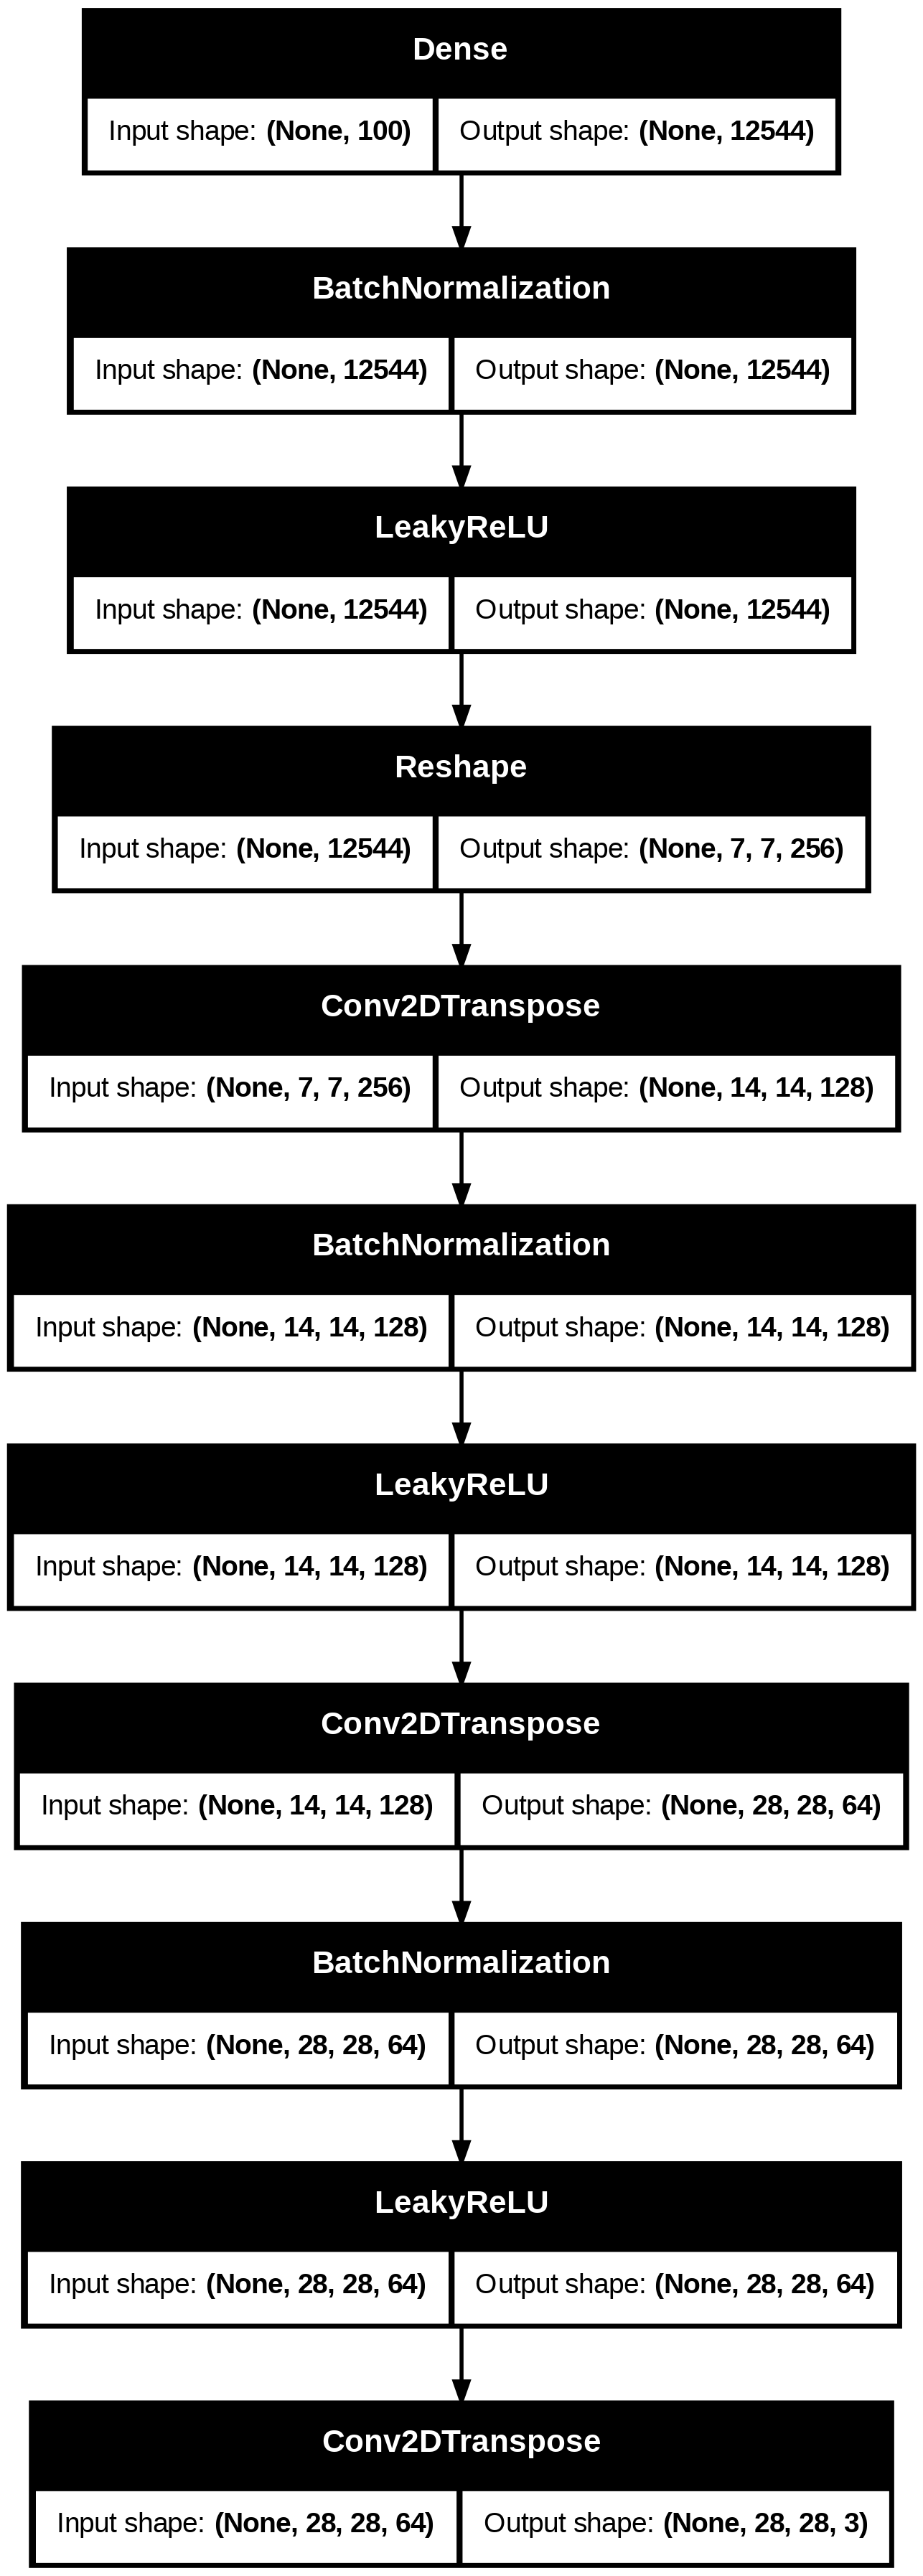

In [ ]:
generator=make_generator()
keras.utils.plot_model(generator,show_shapes=True)

In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

testing the generator model on random vector as input with 100 dim


(1, 28, 28, 3)


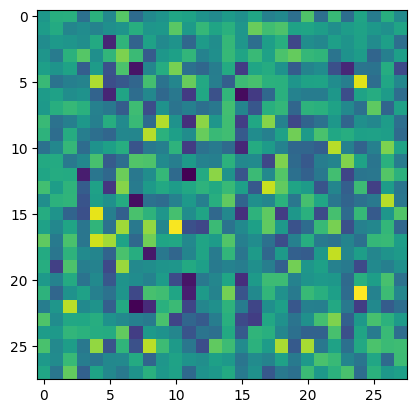

In [ ]:
noise = tf.random.normal([1, 100])#[1,100] one row with 100 columns

# forward-pass through the generator
generated_image = generator(noise, training=False)
print(generated_image.shape)
#(1, 28, 28, 3) this is the shape of the image it printed
plt.imshow(generated_image[0, :, :, 0])

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


tf.Tensor([[0.00316791]], shape=(1, 1), dtype=float32)


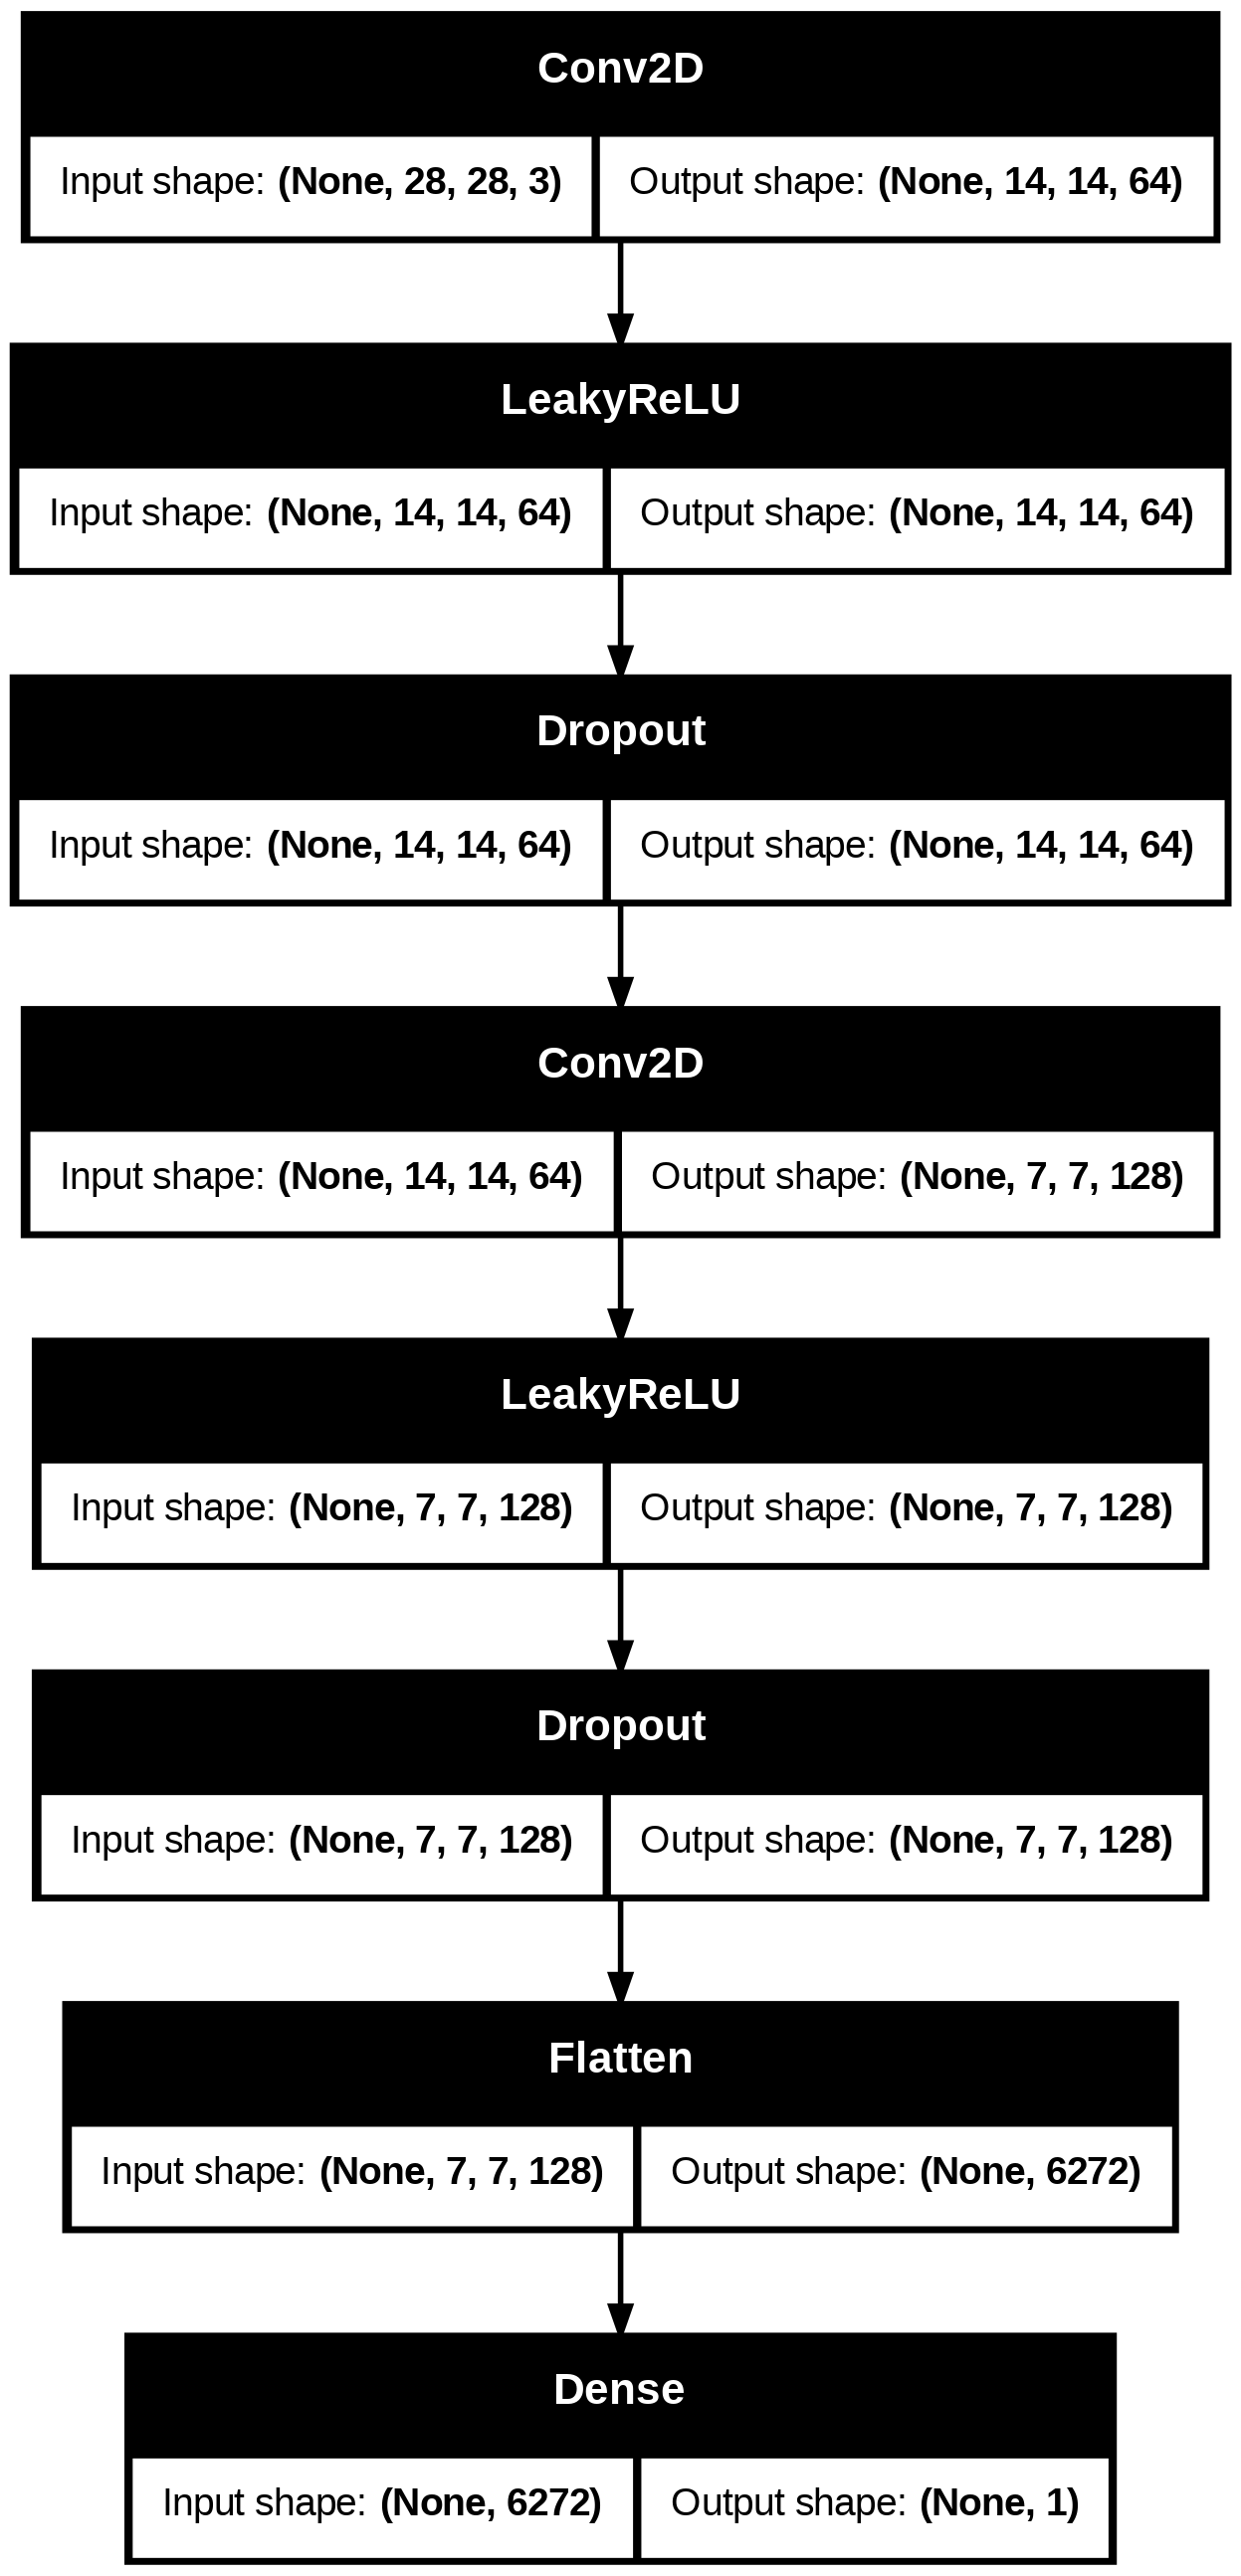

In [ ]:
discriminator=make_discriminator_model()
print(discriminator(generated_image))
keras.utils.plot_model(discriminator,show_shapes=True)

In [ ]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,065 (844.00 KB)

 Trainable params: 216,065 (844.00 KB)

 Non-trainable params: 0 (0.00 B)

#defining the losses


In [ ]:
cross_entrophy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output,fake_output):
  fake_loss=cross_entrophy(tf.zeros_like(fake_output),fake_output)#ideal thing:on passing the fake image the d has to produce zero
  #the loss that is being computed when the fake image is passed from the discriminaotr
  #any deviation from the zero adds to fake loss(on being fake image is passed)
  real_loss=cross_entrophy(tf.ones_like(real_output),real_output)
  total_loss=real_loss+fake_loss
  return total_loss

In [ ]:
def generator_loss(fake_output):
  #on give the random noise to the generator it has to produce the image that discriminator being fooled
  #so the loss is being compared to one
  return cross_entrophy(tf.ones_like(fake_output),fake_output)



# optimizers

In [ ]:
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)


#creating the check points

In [ ]:
checkpoint_dir = './training_checkpoints'#folder where your save files will be stored
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")#actual save files inside your training_checkpoint
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,#specifies exactly what data needs to be saved at each checkpoint
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator) # what objects to store in a ckpt

# Training the model

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse these test_random_vectors overtime (so it's easier)
# to visualize progress in the animated GIF)
test_random_vectors = tf.random.normal([num_examples_to_generate, noise_dim])
print(test_random_vectors.shape)

(16, 100)


In [ ]:
@tf.function
def training_step(images):
  noise=tf.random.normal([BATCH_SIZE,noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:#"record" all the operations that happen inside the with block.
  # This recording is then used to automatically calculate the gradients needed for backpropagation
    generated_images=generator(noise,training=True)#getting the generated images
    real_output=discriminator(images,training=True)#actually passing the real images to get the real output
    fake_output=discriminator(generated_images,training=True)#getting the fake output through the discriminator to get the fake output

    gen_loss=generator_loss(fake_output)#giving the fake ouput to generator to produce the gen loss
    disc_loss=discriminator_loss(real_output,fake_output)


    gradients_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
    #recording" from the GradientTape is played back to calculate the gradients—the exact adjustments
    # needed for each weight in the models to reduce their respective losses
    gradients_of_discriminator=disc_tape.gradient(disc_loss,discriminator.trainable_variables)


    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    #the optimizers take these calculated adjustments and apply them to the weights of
    #the generator and discriminator. This is the moment of learning,
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))



https://g.co/gemini/share/efd7bf9184a8 whole of explaination of the above function

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      training_step(image_batch)
      #for very image batch we are training the model and with test vector we are getting the output
      #from the generate_and_save_images

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             test_random_vectors)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           test_random_vectors)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

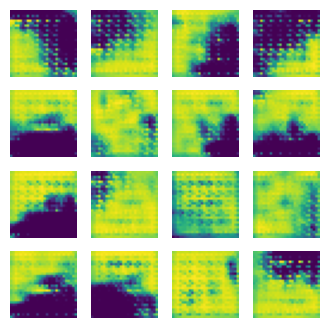

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
# The '-r' flag means 'recursive', which is needed to copy the whole folder
# Replace './training_checkpoints' with the actual path to your checkpoint folder
# Replace '/content/drive/My Drive/my_gan_project/' with your desired destination

!cp -r './training_checkpoints' '/content/drive/My Drive/my_gan_project/'